# MPG analysis and prediction

Your task is to analyze the mpg dataset using techniques learned in the course and create a multiple linear regression model to predict `mpg` (miles per gallon).

The notebook consists of two parts:

  1. Analyzing the data (summary statistics and graphical analysis)
  2. Creating a multiple linear regression model
  
In comparison with the course, there are two new concepts:
  1. Dummy variables for categorical attributes
  2. Train-test dataset split and mean absolute error (MAE)
  
These concepts will be explained in the appropriate sections.





### Data Description

The data we are using is modified [auto mpg](https://archive.ics.uci.edu/ml/datasets/auto+mpg) dataset taken from UCI repository.

Information regarding data<br>
&emsp;&emsp;&emsp;&emsp;**Title:** Auto-Mpg Data<br>
&emsp;&emsp;&emsp;&emsp;**Number of Instances:** 398<br>
&emsp;&emsp;&emsp;&emsp;**Number of Attributes:** 6 <br>
&emsp;&emsp;&emsp;&emsp;**Attribute Information:**

    1. mpg:           continuous
    2. displacement:  continuous
    3. horsepower:    continuous
    4. weight:        continuous
    5. model year:    multi-valued discrete
    6. origin:        multi-valued discrete
    
All the attributes are self-explanatory, except (maybe) displacement. ([definition](https://en.wikipedia.org/wiki/Engine_displacement)).

### Tasks

1. Load CSV data into a pandas DataFrame.
2. Explore data:
   * Specify which variables are numerical and which are categorical variables.
   * Calculate number of unique values for each variable.
   * Detect missing values (`NaN` values).
3. If there are any `NaN` values, filter them out.






### Hints

1. As there are too few observations for the `model_year` variable, it can be analyzed as a categorical variable.
2. A useful method for the description of data types is `.info()`.


In [1]:
# import all necessary libraries
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

We will first import the data into a pandas dataframe and inspect it's properties.

In [2]:
# # URL of the mpg dataset

# Original dataset
# url = 'https://raw.githubusercontent.com/mwaskom/seaborn-data/master/mpg.csv'

# # Load the dataset from the url
# df = pd.read_csv(url)

# #Modify dataset for this quiz
# df.drop(columns=["acceleration", "cylinders","name"],inplace=True)

# #remove extra spaces if any
# for col in ['origin']:
#     df[col] = df[col].apply(lambda x: ' '.join(x.split()))

# # Save the DataFrame to a CSV file
# df.to_csv('mpg.csv', index=False)


# Load the dataset from the
df = pd.read_csv('https://gist.githubusercontent.com/Ruzejjur/7c3507e8e99a1013658db5f5eace3d33/raw/a86c1ac1e377fa9609109816df8942f13d2f327c/gistfile1.txt')

# Display the first few rows of the dataset
df.head()


,mpg,displacement,horsepower,weight,model_year,origin
0,18.0,307.0,130.0,3504,70,usa
1,15.0,350.0,165.0,3693,70,usa
2,18.0,318.0,150.0,3436,70,usa
3,16.0,304.0,150.0,3433,70,usa
4,17.0,302.0,140.0,3449,70,usa


In [3]:
# So now the data is in rectangular form with 398 entries each having 6 distinct properties
df.shape

(398, 6)

In [4]:
# Let's list all the columns
columns = list(df.columns)
columns

['mpg', 'displacement', 'horsepower', 'weight', 'model_year', 'origin']

In [5]:
# We now describe the properties of this dataframe like column datatype etc.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   displacement  398 non-null    float64
 2   horsepower    392 non-null    float64
 3   weight        398 non-null    int64  
 4   model_year    398 non-null    int64  
 5   origin        398 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 18.8+ KB


We now make two distinct list for categorical and numerical column names as the analysis differ for both the types. For that we introspect the datatypes of each column and if it is of type `object` then it's categorical and else numerical.

In [6]:
cats = list(df.select_dtypes(include=['object']).columns)
nums = list(df.select_dtypes(exclude=['object']).columns)
print(f'categorical variables:  {cats}')
print(f'numerical variables:  {nums}')

categorical variables:  ['origin']
numerical variables:  ['mpg', 'displacement', 'horsepower', 'weight', 'model_year']


In [7]:
# Let's inspect how many unique values are there in each column.
df.nunique(axis=0)

mpg             129
displacement     82
horsepower       93
weight          351
model_year       13
origin            3
dtype: int64

As there are very few unique values for `model_year`, we are going to interpret this variable as categorical.

In [8]:
# Cylinders and model_year also seems to be categorical so lets update the lists
cats.extend(['model_year'])
nums.remove('model_year')

print(f'categorical variables:  {cats}')
print(f'numerical variables:  {nums}')

categorical variables:  ['origin', 'model_year']
numerical variables:  ['mpg', 'displacement', 'horsepower', 'weight']


Now inspect for `NaN`'s in data.



In [9]:
# Check for `nans` in each column
df.isna().sum()

mpg             0
displacement    0
horsepower      6
weight          0
model_year      0
origin          0
dtype: int64

In [10]:
# Let's print these 6 `nan` containing rows
df[df.isnull().any(axis=1)]

,mpg,displacement,horsepower,weight,model_year,origin
32,25.0,98.0,NaN,2046,71,usa
126,21.0,200.0,NaN,2875,74,usa
330,40.9,85.0,NaN,1835,80,europe
336,23.6,140.0,NaN,2905,80,usa
354,34.5,100.0,NaN,2320,81,europe
374,23.0,151.0,NaN,3035,82,usa


In [11]:
# NaN rows proportion in data
print(f"Proportion of NaN's in the dataset: {(6 / len(df) * 100):.2f}%.")

Proportion of NaN's in the dataset: 1.51%.


So horsepower consists of total of 6 `NaN` rows comprising of around 1.5% of data. As this proportion is very low it is safe to drop these `NaN` rows.

In [12]:
# For now remove all nan rows as they are just 1.5%

# Filter out the rows containing NaN
df = df[~df.isnull().any(axis=1)]

In [13]:
# inspect the shape of cleaned dataset
df.shape

(392, 6)

In [14]:
# Inspect total duplicate entries
print(f'total duplicate rows: {df.duplicated().sum()}')

# Drop duplicate rows if any (tehre are none so this opertaion does nothing)
df = df[~df.duplicated()]

total duplicate rows: 0


In [15]:
# Displaing dataset for comparison with the output of the next code block
df.head()

,mpg,displacement,horsepower,weight,model_year,origin
0,18.0,307.0,130.0,3504,70,usa
1,15.0,350.0,165.0,3693,70,usa
2,18.0,318.0,150.0,3436,70,usa
3,16.0,304.0,150.0,3433,70,usa
4,17.0,302.0,140.0,3449,70,usa


In [16]:
# Before we move ahead it's a good practice to group all variables together having same type
# (this just changes the ordering of columns)
df = pd.concat((df[cats], df[nums]), axis=1)
df.head()

,origin,model_year,mpg,displacement,horsepower,weight
0,usa,70,18.0,307.0,130.0,3504
1,usa,70,15.0,350.0,165.0,3693
2,usa,70,18.0,318.0,150.0,3436
3,usa,70,16.0,304.0,150.0,3433
4,usa,70,17.0,302.0,140.0,3449


In [17]:
# Save the dimensions of the dataframe for later use
num_rows, num_cols = df.shape

Now we are ready for deeper analysis.

# Analysis of variables

Analyze the categorical and numerical variables separately.

## Analysis of categorical variables


### Tasks

1. Subset the dataset only for the categorical variables.
2. Explore unique values of these variables.
3. Calculate summary statistics for those categorical variables which are numeric:
   * min
   * max
   * mean
   * median
   * variance
   * standard deviation
4. Create graphical analysis of the categorical variables:
   * Create a count plot for each categorical variable (use `sns.countplot()`).
5. Describe the insights from the analysis:
   * Is the dataset balanced with respect to individual categories?


### Hints

1. A useful method for the summary statistics is `.describe()` from the pandas package.
2. We would like the data to be evenly represented across categories (i.e., uniformly distributed). Are the data uniformly distributed across the categories?


In [18]:
# Printing the categorical variables as a reminder of what is being examined
print(f'categorical variables:  {cats}')

categorical variables:  ['origin', 'model_year']


We will first slice out the categorical columns from the original dataframe and then perform the analysis on it, keeping the original data untouched. At the end, we will incorporate any needed changes into our original dataframe.


In [19]:
# Creating a copy of the dataset only with the categorical variables
df_cat = df.loc[:, 'origin':'model_year']
df_cat.head(10)

,origin,model_year
0,usa,70
1,usa,70
2,usa,70
3,usa,70
4,usa,70
5,usa,70
6,usa,70
7,usa,70
8,usa,70
9,usa,70


In [20]:
# Let's look at the unique categories in `origin`, `model_year`

print(f"categories in origin: {pd.unique(df_cat['origin'])}")
print(f"categories in model_year: {pd.unique(df_cat['model_year'])}")

categories in origin: ['usa' 'japan' 'europe']
categories in model_year: [70 71 72 73 74 75 76 77 78 79 80 81 82]


In [21]:
# Although descriptive statistics for categorical variables are not very informative,
# it is still worth examining the variables that are categorical but have a numeric type.

# Also pandas describe function is only for numeric data and in df_cat `model_year` are the only numeric type.
df_cat.describe()

,model_year
count,392.000000
mean,75.979592
std,3.683737
min,70.000000
25%,73.000000
50%,76.000000
75%,79.000000
max,82.000000


Not much insight from these specific variables apart from the min and max of `model_year`.


### Graphical analysis

Now we analyse the distribution for each categorical feature and make some insights from the plots.

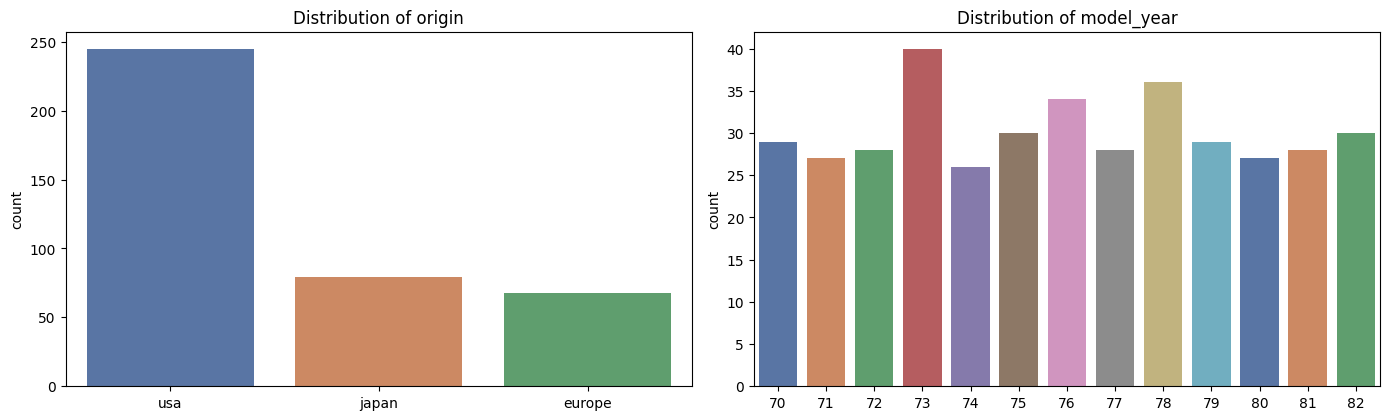

In [22]:
# Set up the figure with a specified size
fig = plt.figure(1, (14, 8))

# Define a color palette for plots
palette = "deep"

# Loop through each categorical column
for i, cat in enumerate(df_cat):
    # Create a subplot for each categorical variable

    # Note 1: First two numbers define the grid dimensions (2x2)
    # Note 2: i + 1 shifts the subplot index (matplotlib indexing starts from 1)
    ax = plt.subplot(2, 2, i + 1)

    # Create a count plot for the current categorical variable using
    # seaborn.countplot
    #
    # Note 1: ax specifies the object to be plot unto
    sns.countplot(data=df_cat, x=cat, hue=cat, palette=palette, ax=ax, legend=False)


    # Remove the x-axis label for a cleaner look
    ax.set_xlabel(None)

    # Set the title for the subplot
    ax.set_title(f'Distribution of {cat}')

    # Adjust the layout to prevent overlapping elements
    plt.tight_layout()

# Display the plots
plt.show()


In [23]:
# calculate proportion of dominant classes in each category
for i,cat in enumerate(df_cat):
    # Calculate counts for category cat
    val_counts = df_cat[cat].value_counts()
    # Get the most frequent value of cat and calculate proportion to all of the
    # observations
    dominant_frac = val_counts.iloc[0] / num_rows

    # Extracting the most frequent count value for the category and casting propotion to %
    print(f'For {cat}: `{val_counts.index[0]}` alone contributes to {round(dominant_frac * 100, 2)}% of {cat}')

For origin: `usa` alone contributes to 62.5% of origin
For model_year: `73` alone contributes to 10.2% of model_year


### Insights
* `origin` is highly imbalanced, `usa` alone consists of 62.5% of data whereas `japan` & `europe` are having similar proportion.
* `model_year` is considerably balanced which is good.

In [24]:
# Examine the dataframe as a reminder
df.head()

,origin,model_year,mpg,displacement,horsepower,weight
0,usa,70,18.0,307.0,130.0,3504
1,usa,70,15.0,350.0,165.0,3693
2,usa,70,18.0,318.0,150.0,3436
3,usa,70,16.0,304.0,150.0,3433
4,usa,70,17.0,302.0,140.0,3449


## Analysis on Numerical Attributes

### Tasks

1. Subset the dataset only for the numerical variables.
2. Calculate summary statistics for these variables:
   * min
   * max
   * mean
   * median
   * variance
   * standard deviation
3. Create graphical analysis of the numeric variables:
   * Create one (or more) of the following plots for each numeric variable:
      * Histogram (`sns.histplot()`)
      * Box plot (`sns.boxplot()`)
      * Violin plot (`sns.violinplot()`)
4. Analyze the relationships between individual numerical variables:
   * Use `sns.pairplot()`.
5. Describe the insights from the analysis:
   * Describe the distribution of individual numeric variables.
   * Are there any linear relationships between the numeric variables?
     * For example: If the weight increases, does the horsepower increase/decrease?


### Hints

1. A useful method for the summary statistics is `.describe()` from the pandas package.


In [25]:
# Printing the numerical variables as a reminder of what is being examined
print(f'numerical variables:  {nums}')

numerical variables:  ['mpg', 'displacement', 'horsepower', 'weight']


We will first slice out the numerical columns from the original dataframe and then perform the analysis on it, keeping the original data untouched. At the end, we will incorporate any needed changes into our original dataframe.


In [26]:
# Subset the mpg column
df_num = df.loc[:, 'mpg':]

Let's first look at some descriptive stats.



In [27]:
df_num.describe()

,mpg,displacement,horsepower,weight
count,392.000000,392.000000,392.000000,392.000000
mean,23.445918,194.411990,104.469388,2977.584184
std,7.805007,104.644004,38.491160,849.402560
min,9.000000,68.000000,46.000000,1613.000000
25%,17.000000,105.000000,75.000000,2225.250000
50%,22.750000,151.000000,93.500000,2803.500000
75%,29.000000,275.750000,126.000000,3614.750000
max,46.600000,455.000000,230.000000,5140.000000


The mean and median of displacement are considerably different, suggesting that the data are spread out and do not accumulate around the mean.


### Graphical analysis

Now we analyse the distribution for each numerical attribute and make some insights from the plots.

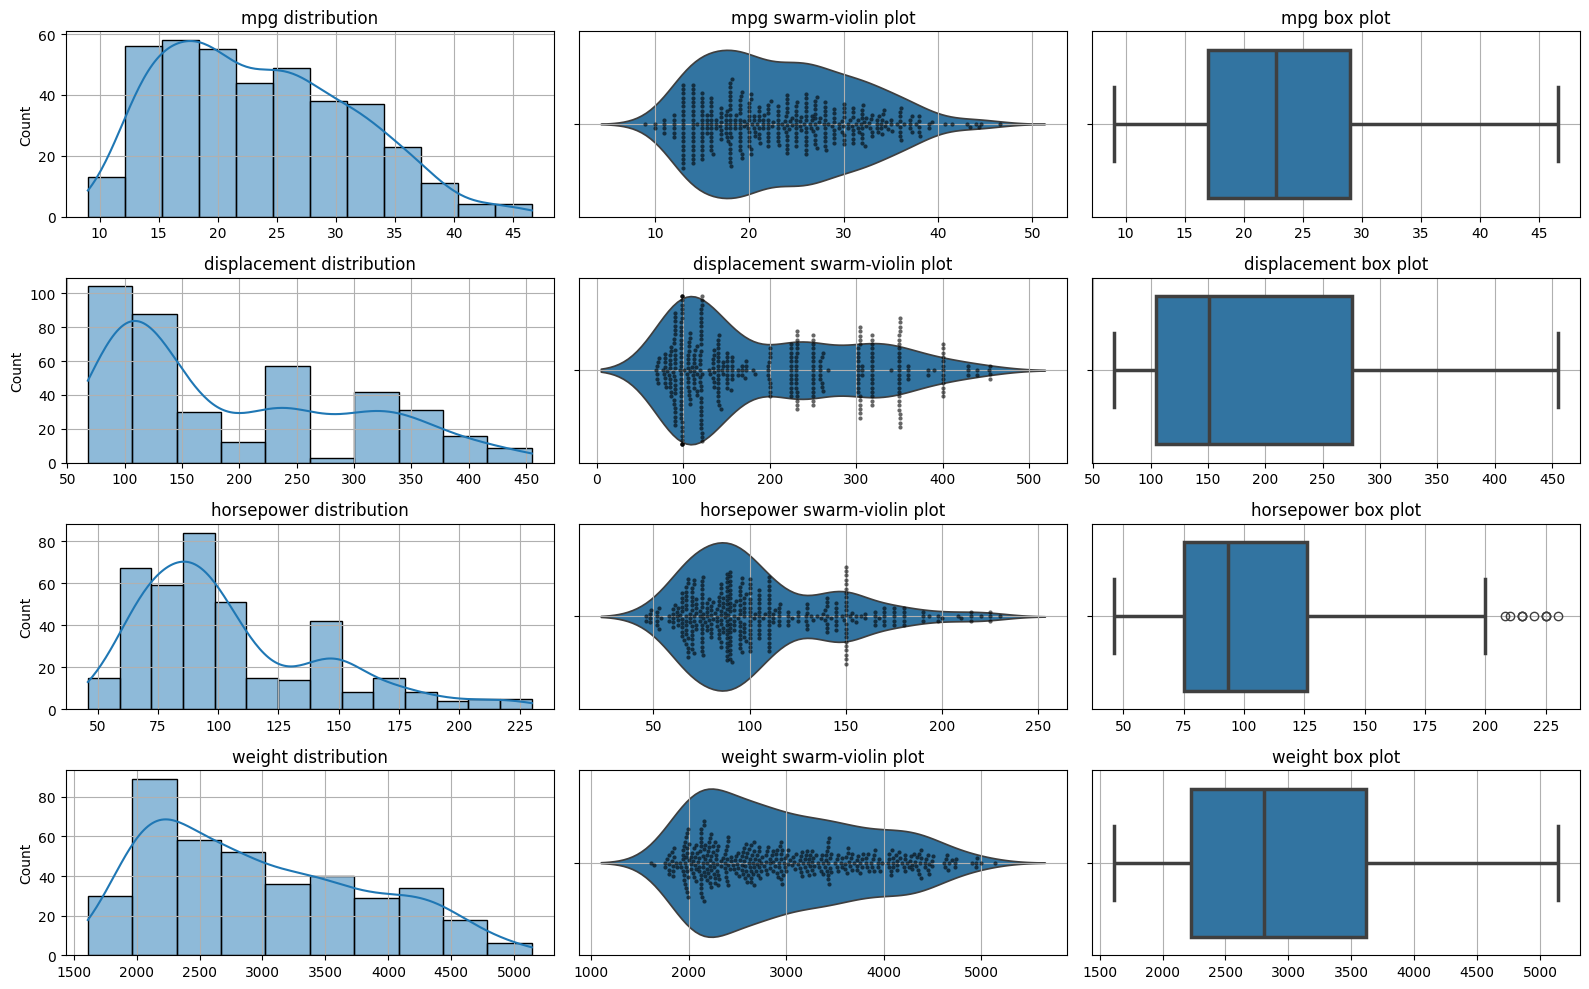

In [28]:
# List of numerical columns
nums = df_num.columns

# Define number of rows in subplot grid
rows = len(nums)

# Define number of columns in subplot grid
cols = 3

# Initialize figure with specific size
fig = plt.figure(1, (16, rows * 2.5))

# Size of the markers (dots in swarm-violin plot)
marker_size = 3

# Whether to use stripplot instead of swarmplot
# Note 1: There are not many observations, so there is no issue with using a
# swarm plot
use_stripplot = False

# Initialize subplot index
i = 0

# Loop through each numerical column to create subplots
for col in nums:
    i += 1
    # Create histogram with KDE subplot
    ax1 = plt.subplot(rows, cols, i)
    sns.histplot(df_num[col], ax=ax1, kde=True)
    ax1.set_xlabel(None)  # Remove x-axis label
    ax1.set_title(f'{col} distribution')  # Set title for the subplot
    ax1.grid(True)  # Turn on the grid
    plt.tight_layout()  # Adjust the layout to prevent overlapping elements

    i += 1
    # Create violin plot subplotx
    ax2 = plt.subplot(rows, cols, i)
    sns.violinplot(x=df_num[col], ax=ax2, inner=None)
    if use_stripplot:
        # Overlay stripplot on the violin plot
        sns.stripplot(x=df_num[col], ax=ax2, size=marker_size, color='k', alpha=0.6)
    else:
        # Overlay swarmplot on the violin plot
        sns.swarmplot(x=df_num[col], ax=ax2, size=marker_size, color='k', alpha=0.6)

    ax2.set_xlabel(None)  # Remove x-axis label
    ax2.set_title(f'{col} {"strip" if use_stripplot else "swarm"}-violin plot')  # Set title for the subplot
    ax2.grid(True)  # Turn on the grid
    plt.tight_layout()  # Adjust the layout to prevent overlapping elements

    i += 1
    # Create box plot subplot
    ax3 = plt.subplot(rows, cols, i)
    sns.boxplot(x=df_num[col], ax=ax3, orient='h', linewidth=2.5)
    ax3.set_xlabel(None)  # Remove x-axis label
    ax3.set_title(f'{col} box plot')  # Set title for the subplot
    ax3.grid(True)  # Turn on the grid
    plt.tight_layout()  # Adjust the layout to prevent overlapping elements

# Show all the subplots
plt.show()


### Insights
* The distributions of `mpg` and `weight` seem to be right-skewed Gaussian.
* The distributions of `displacement` and `horsepower` seem to be far from Gaussian.
* `Horsepower` contains outliers.


Let's examine the outliers in `horsepower`.

In [29]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
outlier_to_be_examined = 'horsepower'
Q1 = df[outlier_to_be_examined].quantile(0.25)
Q3 = df[outlier_to_be_examined].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bound for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Extract outliers
outliers = df[(df[outlier_to_be_examined] < lower_bound) | (df[outlier_to_be_examined] > upper_bound)]
outliers

,origin,model_year,mpg,displacement,horsepower,weight
6,usa,70,14.0,454.0,220.0,4354
7,usa,70,14.0,440.0,215.0,4312
8,usa,70,14.0,455.0,225.0,4425
13,usa,70,14.0,455.0,225.0,3086
25,usa,70,10.0,360.0,215.0,4615
27,usa,70,11.0,318.0,210.0,4382
67,usa,72,11.0,429.0,208.0,4633
94,usa,73,13.0,440.0,215.0,4735
95,usa,73,12.0,455.0,225.0,4951
116,usa,73,16.0,400.0,230.0,4278


* All outliers are from the USA.
* The outliers are not incorrectly input observations. As will be seen from further analysis of categorical vs. numerical variables, cars from the USA have higher horsepower than cars of Japanese and European origin. Individual variables seem to be consistent with high `horsepower` cars. These cars are just not sufficiently represented in the data.


**Now we analyze relationship between different numerical attributes**

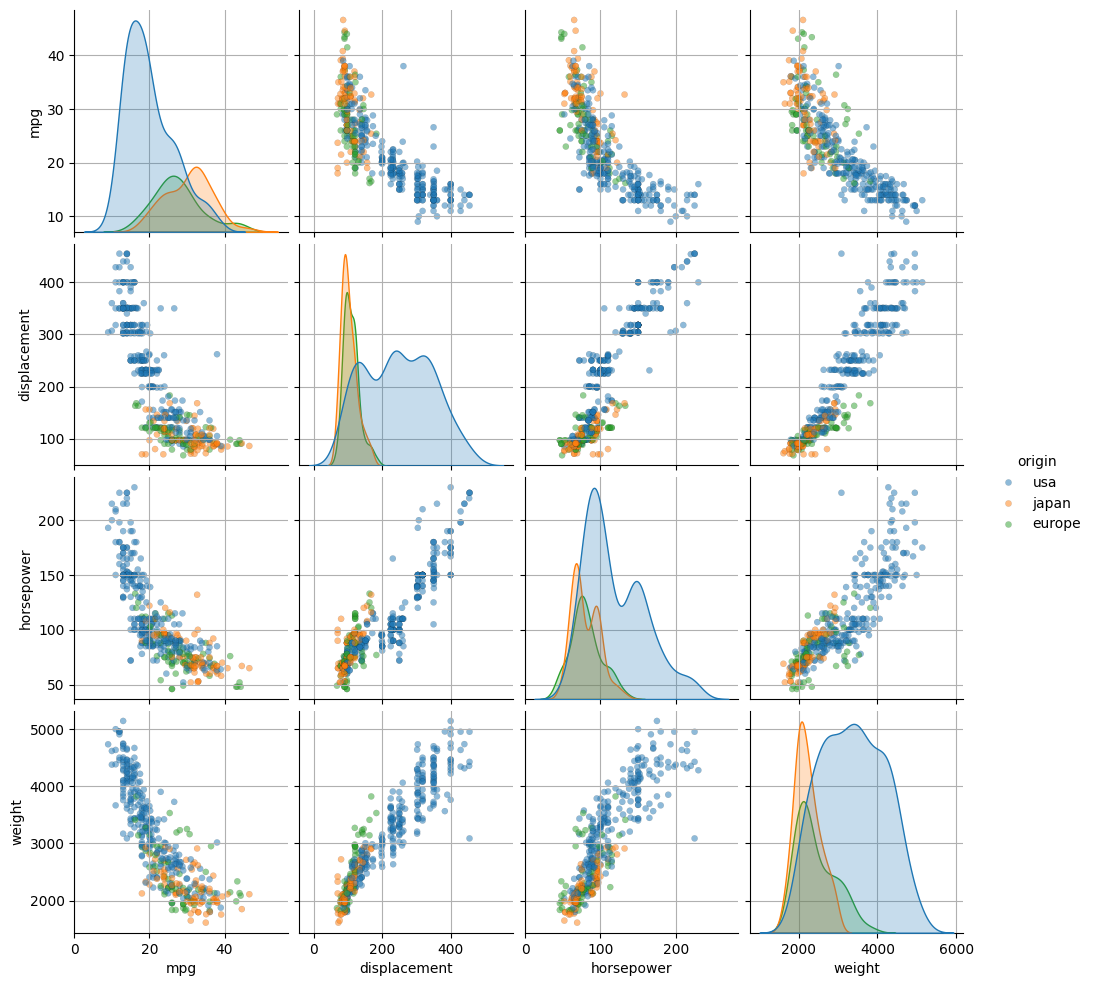

In [30]:
# Save name of the columns to be examined
nums = df_num.columns

# Create a pairplot
g = sns.pairplot(
    data=df,
    vars=nums,
    diag_kind='kde',  # Use kernel density estimation for diagonal plots
    hue='origin',  # Color code by 'origin' column
    plot_kws=dict(s=20, edgecolor="k", linewidth=0.1, alpha=0.5),  # Customize scatter plot appearance
    diag_kws=dict(fill=True)  # Customize KDE plot appearance, using fill instead of shade
)

# Iterate through each Axes in the PairGrid
for ax in g.axes.flatten():
    ax.grid(True)  # Turn on the grid for each Axes

# Display the plot
plt.show()



### Insights

* As `mpg` increases, `displacement`, `horsepower`, and `weight` decrease.
* As `displacement` increases, `horsepower` and `weight` increase.
* As `horsepower` increases, `displacement` and `weight` increase.
* As `weight` increases, `displacement` increases.

The insights from numerical values separated by categories will be examined more clearly in the next sections.


**So all numerical attributes are related with each other.**

## Analysis of categorical vs. numerical variables

### Tasks

1. Work with the original dataset (containing both categorical and numeric variables).
2. Explore the relationship between categorical variables and numeric variables:
   * Create box plots of categorical vs. numerical variables for each variable (use `sns.boxenplot()`).
3. (Optional) Create a violin plot of categorical vs. numerical variables for each variable (use `sns.violinplot()`).
4. Create a line plot of `model_year` vs. individual numerical variables.
5. Describe what you found from the plots in tasks 2, 3, and 4.


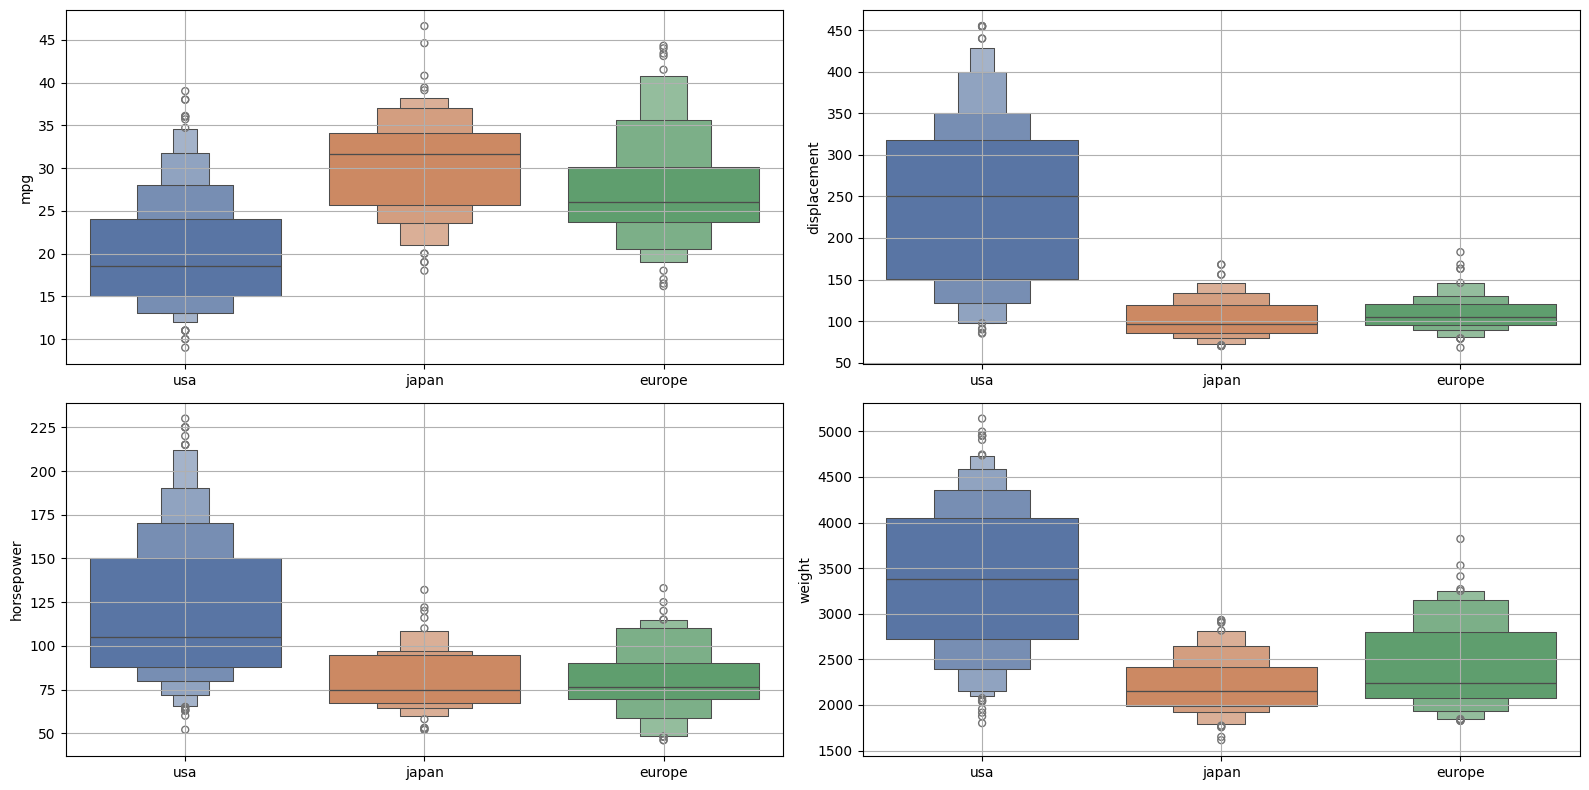

In [31]:
# Variation of numerical features with origin

# Create a figure with a specified size
fig = plt.figure(1, (16, 8))

# Iterate through the numerical columns
for idx, col in enumerate(nums):
    # Create a subplot for each numerical column
    ax = plt.subplot(2, 2, idx + 1)
    # Create a boxen plot for the column, grouped by 'origin'
    sns.boxenplot(x='origin', y=col, data=df, hue='origin', palette=palette, legend=False)
    # Remove the x-axis label for a cleaner look
    ax.set_xlabel(None)
    # Turn on the grid for better readability
    ax.grid(True)
    # Adjust the layout to prevent overlapping elements
    plt.tight_layout()

# Display the plot
plt.show()


### Insights
* Vehicles from the USA have lower `mpg` on average compared to those from Japan and Europe.
* Vehicles from the USA have higher `displacement`, `horsepower`, and `weight` compared to those from Japan and Europe.
* `mpg` in Japan seems to be higher than in Europe, but this is inconclusive.
* Japanese and European vehicles seem to have similar values for individual variables.


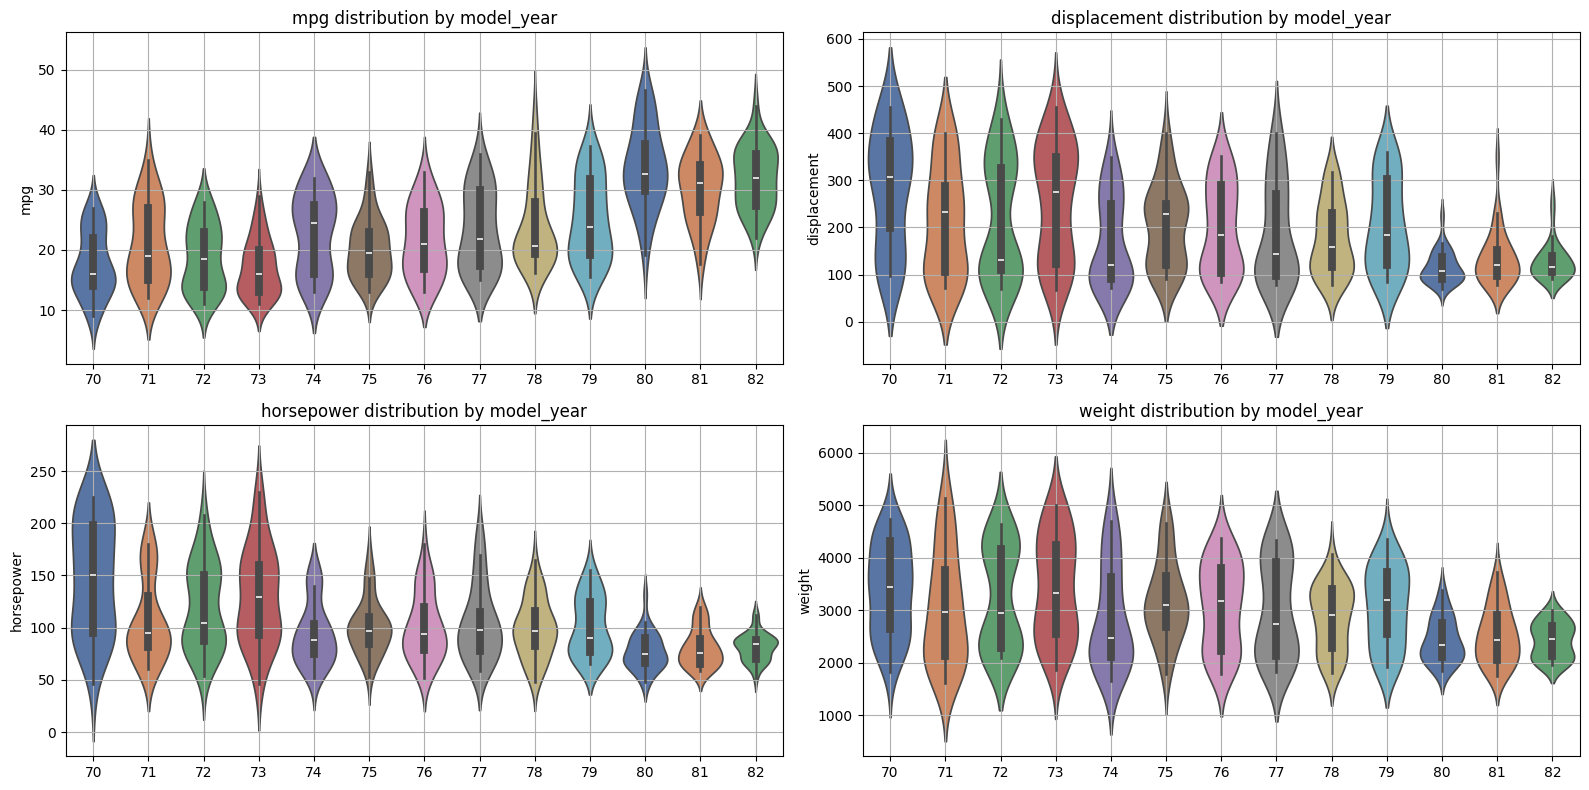

In [32]:
# Variation of numerical features with model_year

# Create a figure with a specified size
fig = plt.figure(1, (16, 8))

# Iterate through the numerical columns
for idx, col in enumerate(nums):
    # Create a subplot for each numerical column
    ax = plt.subplot(2, 2, idx + 1)
    # Create a violin plot for the column, grouped by 'model_year'
    sns.violinplot(x='model_year', y=col, data=df, hue='model_year', palette=palette, dodge=False, legend=False)
    # Remove the x-axis label for a cleaner look
    ax.set_xlabel(None)
    # Turn on the grid for better readability
    ax.grid(True)
    # Set the title for each subplot
    ax.set_title(f'{col} distribution by model_year')
    # Adjust the layout to prevent overlapping elements
    plt.tight_layout()

# Display the plot
plt.show()


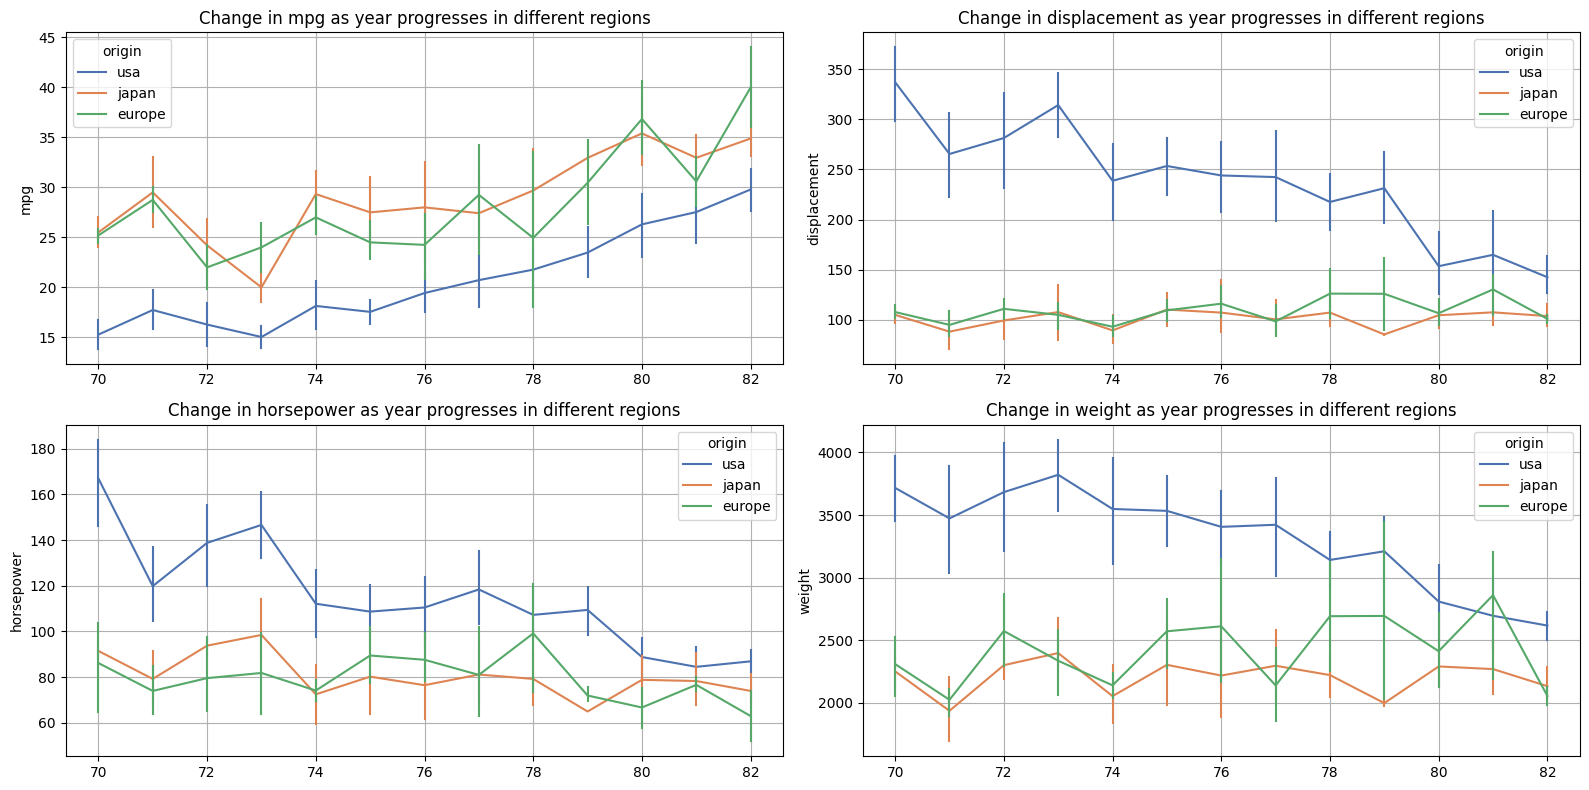

In [33]:
# Variation of numerical features with model_year

# Create a figure with a specified size
fig = plt.figure(1, (16, 8))

# Iterate through the numerical columns
for idx, col in enumerate(nums):
    # Create a subplot for each numerical column
    ax = plt.subplot(2, 2, idx + 1)
    # Create a line plot for the column, grouped by 'model_year' and colored by 'origin'
    sns.lineplot(x="model_year", y=col, hue='origin', data=df, palette=palette, err_style='bars')
    # Set the title for each subplot
    ax.set_title(f'Change in {col} as year progresses in different regions')
    # Remove the x-axis label for a cleaner look
    ax.set_xlabel(None)
    # Turn on the grid for better readability
    ax.grid(True)
    # Adjust the layout to prevent overlapping elements
    plt.tight_layout()

# Display the plot
plt.show()


### Insights
* As model year progresses, there is an increase in `mpg` across all origins.
* As model year progresses, there is a slight decrease in `displacement`, `horsepower`, and `weight` of vehicles belonging to the USA, but there is no significant change in Japan and Europe. One thing we can observe is that in the '80s, all vehicles have similar displacement because, unlike the '70s, the distribution is not spread out (i.e., the distribution is **short and wide** instead of **tall and narrow**).


# Prediction model

### Tasks

Create a multivariable regression model based on the variables in the dataset for prediction of `mpg` based on all other variables.

1. Separate the dependent and independent variables:
   * Name the independent variables dataframe `X`.
   * Name the dependent variable `Y`.
2. Convert any categorical variables into dummy variables using one-hot encoding (for explanation see hints) using the following code (uncomment and incorporate it into your code):

```python
# Convert the categorical variables into dummy variables

# Define names of columns to be converted to dummy variables
cat_columns_to_be_converted = np.array([])  # Add the names of categorical columns here

# Modify the X dataframe of independent variables
X = pd.get_dummies(X, columns=cat_columns_to_be_converted, drop_first=True)

# Convert dummy columns to int as the sm.OLS() requires numerical variables

# For each column in the dataframe
for col in X.columns:
    # Check if the column type is boolean
    if X[col].dtype == 'bool':
        # If yes, make it 0 or 1
        X[col] = X[col].astype(int)



3. Analyze the results:
   * What is the R²? Is it high or low?
   * Are all of the variables statistically significant?
4. Create the residual plot:
   * Are the residuals randomly distributed around 0? Are there any patterns in the residual plot?


### Hints

### One-Hot Encoding
One-hot encoding is a similar technique to dummy variables used in machine learning and data preprocessing to convert categorical data into a binary format. One-hot encoding creates a new binary column for each category in the original categorical variable, and assigns a value of 1 to the column corresponding to the present category, and 0 to all other columns.

Why Use One-Hot Encoding?

Compatibility with Algorithms: Many machine learning algorithms require numerical input and do not work with categorical data directly.
Avoiding Ordinal Relationships: It ensures that no ordinal relationships are implied between the categories.

In [34]:
# Examine the dataframe as a reminder
df.head()

,origin,model_year,mpg,displacement,horsepower,weight
0,usa,70,18.0,307.0,130.0,3504
1,usa,70,15.0,350.0,165.0,3693
2,usa,70,18.0,318.0,150.0,3436
3,usa,70,16.0,304.0,150.0,3433
4,usa,70,17.0,302.0,140.0,3449


### Testing model for prediction accuracy

In [35]:
# Prepare the data for multiple regression
X = df.copy(deep=True)

# Names of clomuns to be converted using one-hot encoding
cat_columns_to_be_converted = np.array(['origin', "model_year"])

# Convert the categorical variables into dummy variables
X = pd.get_dummies(X, columns=cat_columns_to_be_converted, drop_first=True)

# Convert dummy columns to int as the sm.OLS() requires numerical variables
for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = X[col].astype(int)

X.head()
# Separate the target variable
Y = df['mpg']

# Drop the target variable from the predictors in the one-hot encoded DataFrame
X.drop(columns=['mpg'], inplace=True)

# Add a constant term to the predictors
X = sm.add_constant(X)

# # Fit the model
model = sm.OLS(Y, X)
results = model.fit()

# Print the summary of the regression results
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     129.1
Date:                Sun, 14 Jul 2024   Prob (F-statistic):          9.46e-145
Time:                        18:12:32   Log-Likelihood:                -983.54
No. Observations:                 392   AIC:                             2003.
Df Residuals:                     374   BIC:                             2075.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            40.0637      1.095     36.580

In [36]:
# Make predictions
predictions = results.predict(X)

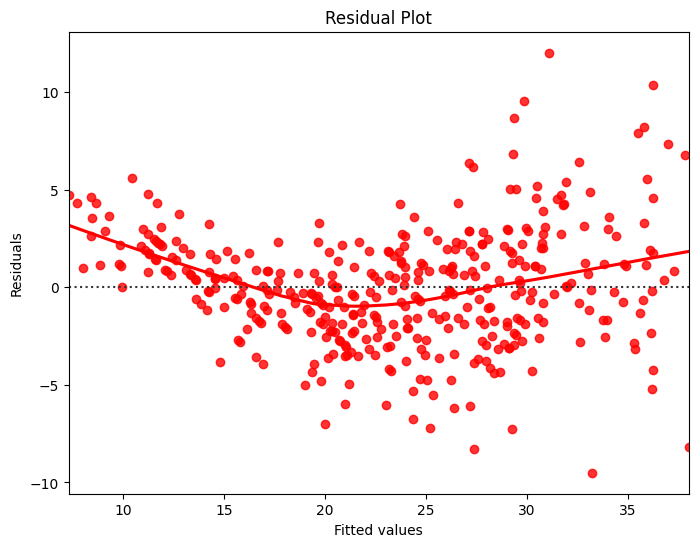

In [37]:
# Plot the residuals

# Calculate residuals
residuals = df['mpg'] - predictions

# Create a figure with a specified size
plt.figure(figsize=(8, 6))

# Create a residual plot
sns.residplot(x=predictions, y=residuals, lowess=True, color='r')

# Set the x-axis label
plt.xlabel('Fitted values')

# Set the y-axis label
plt.ylabel('Residuals')

# Set the title of the plot
plt.title('Residual Plot')

# Display the plot
plt.show()

* Some categories have a p-value > 0.05, which means they are insignificant. However, this is not an issue for the model constructed for prediction. Additionally, it is not good practice to remove only some of the categories from the categorical variable.
* The $R^2 \approx 0.8$ is considered to be high, indicating that the model is quite good.
* Residuals should be randomly distributed around 0, but there is a clear pattern in the residual graph. This means that the model cannot be reliably used to test if the relationship between dependent and independent variables is statistically significant. However, this does not mean that we cannot use the model for prediction purposes.


## Testing model accuracy

## DO NOT MODIFY THIS CODE!!!

Just run it after you are finished with the previous sections.


In this section, the model you trained above is going to be evaluated using repeated random Train-Test dataset splitting.

The dataset is going to be split into two parts:
1. *Train dataset* - This is the dataset on which the model is going to be trained.
2. *Test dataset* - This is the set of data which the model 'has not seen yet' and it is used to test how well the model predicts `mpg` with new data.

The splitting is done 1000 times, randomly assigning data to Train and Test datasets. The split is as follows:
1. 80% is assigned to the Train dataset.
2. 20% is assigned to the Test dataset.

On each iteration, Mean Absolute Error (**MAE**) is calculated.

**MAE** is defined as the average absolute difference between the actual values and the predicted values.

Mathematically, it is given by:

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$

So if MAE is 0, this means that the model predicts the values exactly. In reality, MAE = 0 is not achievable, so our goal is to have MAE as low as possible.


### Tasks

Run the code below and describe the results.

How good is our model for the prediction of `mpg` based on other variables?
i.e. How precise is your model in predicting the `mpg`?


### Hints

It is crucial to name the independent variables dataset as `X` and the dependent variable as `Y` for the code below to function.


Min. model MAE 1.7796391738447213
Max. model MAE 3.0548895197270953
Mean model MAE 2.413266160113092
Median model MAE 2.4147055322061988


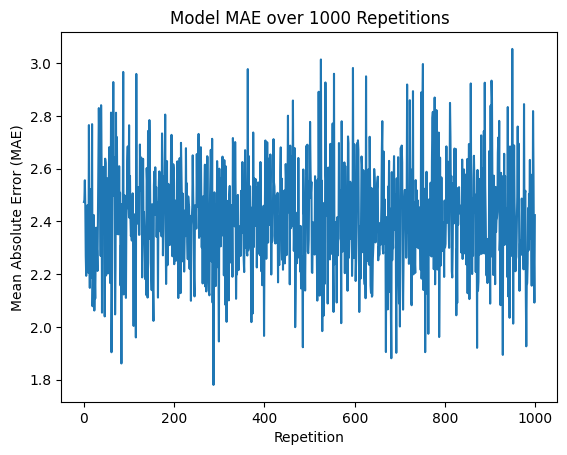

In [38]:
import statistics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm

model_accuracies = []

for repetition in range(1000):
    # Split the dataset into training and testing sets
    (training_inputs, testing_inputs, training_values, testing_values) = train_test_split(X, Y, test_size=0.2)

    # Add a constant to the training inputs
    training_inputs = sm.add_constant(training_inputs)
    testing_inputs = sm.add_constant(testing_inputs)

    # Train the model using the training set with sm.OLS
    model = sm.OLS(training_values, training_inputs).fit()

    # Predict the values on the testing set
    predictions = model.predict(testing_inputs)

    # Calculate the mean absolute error on the testing set
    mae = mean_absolute_error(testing_values, predictions)
    model_accuracies.append(mae)

# Print the results
print("Min. model MAE", min(model_accuracies))
print("Max. model MAE", max(model_accuracies))
print("Mean model MAE", statistics.mean(model_accuracies))

print("Median model MAE", statistics.median(model_accuracies))

# Plot the model accuracies
x = np.array(range(1000))
plt.plot(x, model_accuracies)
plt.xlabel('Repetition')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Model MAE over 1000 Repetitions')
plt.show()


### Insights

* We can say that our model can predict `mpg` with an average error of 2.55, which can be useful.
* The model can be further improved by adding other variables. A better model can be constructed using the original unmodified `mpg` dataset.


<div style="font-style: italic; font-size: 14px;">
    <p>This material was prepared by Department of Information Engineering (<a href="https://www.pef.czu.cz/en">PEF ČZU</a>) exclusively for purposes of ELLS summer school "Practical Introduction into Programming with Python". Any distribution or reproduction of this material, in whole or in part, without prior written consent of the authors is prohibited.</p>
    <p>This material is shared under the <b>Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International Public License</b>, <a href="https://creativecommons.org/licenses/by-nc-nd/4.0/">link</a>.</p>
</div>
